In [7]:
from pathlib import Path

from joblib import Memory
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [8]:
DATA_DIR = Path.cwd() / 'data/' # EMG signals
CACHE_DIR = Path.cwd() / 'cache/' # cache previously done computations (via joblib)

memory = Memory(CACHE_DIR)

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a

def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y

@memory.cache
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out


In [10]:
def loadmat(filename):
    file = h5py.File(filename, 'r')
    return np.asarray(file['grid_crds']), np.asarray(file['out_mat'])

if1_grid_crds, if1_out_mat = loadmat(DATA_DIR / r'increasing-force-1.mat')
if2_grid_crds, if2_out_mat = loadmat(DATA_DIR / r'increasing-force-2.mat')
sf1_grid_crds, sf1_out_mat = loadmat(DATA_DIR / r'steady-force-1.mat')

emg = if1_out_mat

In [11]:
print(emg.shape)

(60160, 64)


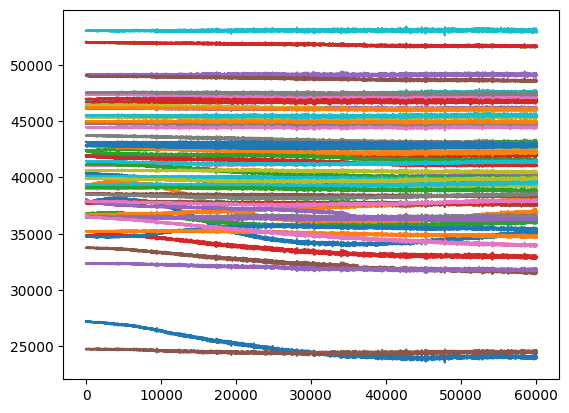

In [12]:
plt.plot(emg)
plt.show()

In [13]:
filtered_if1_out_mat = filt_GRID(emg)

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-2236319871.filt_GRID...
filt_GRID(array([[37753.414062, ..., 52030.175781],
       ...,
       [35028.390625, ..., 51611.378906]]))
_______________________________________________________filt_GRID - 10.8s, 0.2min


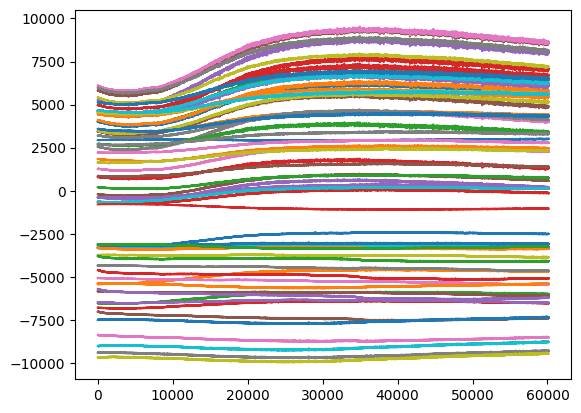

In [14]:
plt.plot(filtered_if1_out_mat)
plt.show()

In [15]:
fastica = FastICA(n_components=filtered_if1_out_mat.shape[1])
ica_fit = memory.cache(fastica.fit)

In [16]:
fastica_model = ica_fit(filtered_if1_out_mat)
IC = fastica_model.transform(filtered_if1_out_mat)
print(IC)

________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.FastICA.fit...
fit(array([[ 2937.36241 , ...,  -791.031837],
       ...,
       [ 3004.710096, ..., -1046.001957]]))


/home/faerryn/mlsp-project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


_____________________________________________________________fit - 21.0s, 0.4min
[[-0.36565228 -0.14834983 -0.34239406 ... -0.41989639 -0.14548433
  -0.06438357]
 [ 0.05071398 -0.04035218  0.04403006 ... -0.34115764 -0.04679633
  -0.11382624]
 [-0.02700783 -0.48859351 -0.42632418 ... -0.11888387 -0.45193749
   0.34955524]
 ...
 [-0.13467865 -1.1320946   0.38191873 ...  0.29117699 -0.02105759
  -0.14308967]
 [-0.02179964 -1.39542827  0.17196961 ...  0.28167869  0.56082695
   0.33997675]
 [-0.06822696 -2.11430496  0.35697593 ...  0.25349026  0.84983387
   0.18796815]]


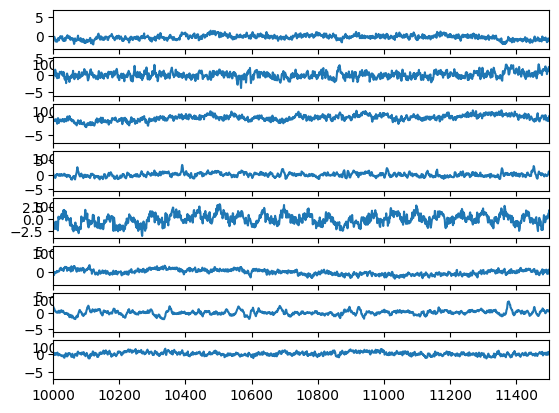

In [17]:
fig, ax = plt.subplots(nrows=IC.shape[1]//8)
for i in range(0, IC.shape[1]//8):
    ax[i].plot(IC[:, i])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()

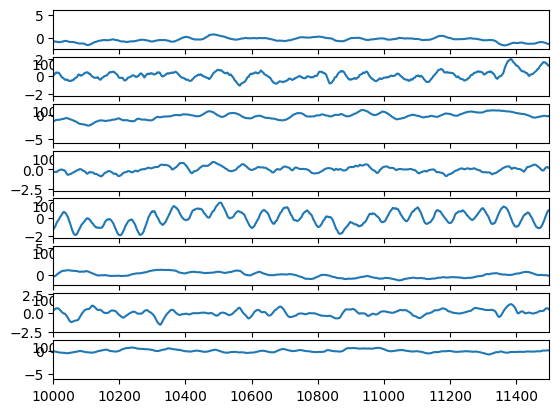

In [24]:
filtered_IC = savgol_filter(IC, 64, 2, axis=0, delta=1024)

fig, ax = plt.subplots(nrows=filtered_IC.shape[1]//8)
for i in range(0, filtered_IC.shape[1]//8):
    ax[i].plot(filtered_IC[:, i])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()